In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import RobertaModel, RobertaTokenizerFast, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import logging
import gc
import random
import logging
import sys

2025-04-15 10:26:39.324090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744712799.493157      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744712799.543266      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Remove all handlers associated with the root logger object
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging to output to sys.stdout
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout
)
logger = logging.getLogger(__name__)

In [3]:
DATA_PATH = '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv'
SAMPLE_SIZE = 100000  # Smaller sample size for faster training
BATCH_SIZE = 8  # Smaller batch size to help with stability
MAX_SENTS = 5
MAX_TOKENS = 50
EPOCHS = 40  # Fewer epochs for testing
LEARNING_RATE = 5e-6  # Lower learning rate for stability
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
logger.info(f"Using device: {DEVICE}")

2025-04-15 10:26:49 - INFO - Using device: cuda


In [5]:
seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
try:
    logger.info(f"Loading data from {DATA_PATH}")
    colnames = ['sentiment', 'id', 'date', 'query', 'user', 'text']
    df = pd.read_csv(DATA_PATH, names=colnames, encoding='latin-1')
    
    # Map labels: 0 -> negative (0), 4 -> positive (1)
    df = df[df.sentiment.isin([0, 4])]
    df['label'] = df.sentiment.map({0: 0, 4: 1})
    df = df[['text', 'label']]
    
    # Check for and handle NaN values
    initial_size = len(df)
    df = df.dropna()
    if len(df) < initial_size:
        logger.warning(f"Dropped {initial_size - len(df)} rows with NaN values")
    
    # Sample if requested
    if SAMPLE_SIZE and SAMPLE_SIZE < len(df):
        df = df.sample(n=SAMPLE_SIZE, random_state=42)
        
    logger.info(f"Data loaded successfully with {len(df)} rows")
    
    # Display class distribution
    class_dist = df['label'].value_counts(normalize=True) * 100
    logger.info(f"Class distribution: {class_dist.to_dict()}")
except Exception as e:
    logger.error(f"Error loading data: {str(e)}")
    raise

2025-04-15 10:26:49 - INFO - Loading data from /kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
2025-04-15 10:26:56 - INFO - Data loaded successfully with 100000 rows
2025-04-15 10:26:56 - INFO - Class distribution: {1: 50.056999999999995, 0: 49.943}


In [7]:
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
# 2. Define Dataset and Collate for hierarchical tokenization
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_sentences=5):
        """
        Dataset for hierarchical processing of tweets
        
        Args:
            texts: List of text strings
            labels: List of labels (0 or 1)
            tokenizer: RoBERTa tokenizer
            max_sentences: Maximum number of sentences per tweet
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_sentences = max_sentences
        
        # Download nltk resources if needed
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt', quiet=True)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Handle empty strings
        if not text or pd.isna(text):
            text = "empty text"
            
        # Split into sentences
        try:
            sentences = nltk.tokenize.sent_tokenize(text)
            # Handle case where sent_tokenize returns empty list
            if not sentences:
                sentences = [text]
        except Exception:
            sentences = [text]
            
        # Ensure we have at least one sentence
        if len(sentences) == 0:
            sentences = [""]
            
        return sentences, label


# Create datasets and dataloaders
train_ds = TweetDataset(
    train_df['text'].tolist(), 
    train_df['label'].tolist(), 
    tokenizer, 
    max_sentences=MAX_SENTS
)
val_ds = TweetDataset(
    val_df['text'].tolist(), 
    val_df['label'].tolist(), 
    tokenizer, 
    max_sentences=MAX_SENTS
)


In [9]:
def collate_fn(batch, tokenizer, max_tokens=50):
    """
    Collate function to tokenize all sentences in batch
    
    Args:
        batch: List of (sentences, label) tuples
        tokenizer: RoBERTa tokenizer
        max_tokens: Maximum number of tokens per sentence
        
    Returns:
        Tuple of (input_ids, attention_mask, sent_mask, labels)
    """
    all_labels = []
    # collect per-sentence encodings
    docs_input_ids = []
    docs_attention_mask = []
    docs_sent_mask = []
    
    # Find max number of sentences across documents in the batch
    max_sents = max(len(item[0]) for item in batch)
    # Ensure max_sents is at least 1
    max_sents = max(1, max_sents)
    
    for sentences, label in batch:
        all_labels.append(label)
        
        # tokenize each sentence
        try:
            enc = tokenizer(
                sentences,
                padding='max_length',
                truncation=True,
                max_length=max_tokens,
                return_tensors='pt'
            )
            input_ids = enc['input_ids']       # [num_sents, max_tokens]
            attention_mask = enc['attention_mask']
            num_sents = input_ids.size(0)
        except Exception as e:
            # Handle tokenization errors by creating empty tensors
            logger.warning(f"Tokenization error: {str(e)}. Using empty tensors.")
            input_ids = torch.zeros((1, max_tokens), dtype=torch.long)
            attention_mask = torch.zeros((1, max_tokens), dtype=torch.long)
            num_sents = 1
        
        # pad sentences to max_sents
        if num_sents < max_sents:
            pad_sents = max_sents - num_sents
            input_ids = torch.cat([input_ids, torch.zeros(pad_sents, max_tokens, dtype=torch.long)], dim=0)
            attention_mask = torch.cat([attention_mask, torch.zeros(pad_sents, max_tokens, dtype=torch.long)], dim=0)
            sent_mask = [1] * num_sents + [0] * pad_sents
        else:
            sent_mask = [1] * max_sents
            
        docs_input_ids.append(input_ids)
        docs_attention_mask.append(attention_mask)
        docs_sent_mask.append(sent_mask)
        
    # stack docs
    input_ids = torch.stack(docs_input_ids, dim=0)         # [B, S, T]
    attention_mask = torch.stack(docs_attention_mask, dim=0) # [B, S, T]
    sent_mask = torch.tensor(docs_sent_mask, dtype=torch.bool)  # [B, S]
    labels = torch.tensor(all_labels, dtype=torch.float)
    
    return input_ids, attention_mask, sent_mask, labels

In [10]:

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: collate_fn(x, tokenizer, max_tokens=MAX_TOKENS),
    num_workers=0  # Set to 0 to avoid potential issues
)
val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: collate_fn(x, tokenizer, max_tokens=MAX_TOKENS),
    num_workers=0  # Set to 0 to avoid potential issues
)

In [11]:
class AttentionLayer(nn.Module):
    """Attention Layer with context vector for HAN"""
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )
        # Initialize context vector with more stable values
        self.context_vector = nn.Parameter(torch.zeros(hidden_size))
        nn.init.normal_(self.context_vector, std=0.02)
        
    def forward(self, sequence, mask=None):
        # sequence: [B, T, hidden]
        # mask: [B, T] boolean mask
        # Apply layernorm for numerical stability
        # Project sequence
        u = self.attention(sequence)                   # [B, T, hidden]
        
        # Compute similarity with context vector
        scores = torch.matmul(u, self.context_vector)  # [B, T]
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(~mask, -1e30)  # Use -1e30 instead of -inf for stability
            
        # Normalize scores
        alpha = torch.softmax(scores, dim=1)           # [B, T]
        
        # Weighted sum
        out = torch.sum(sequence * alpha.unsqueeze(-1), dim=1)  # [B, hidden]
        
        return out, alpha

In [12]:
# 4. Training and evaluation
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, device, 
                 lr=2e-5, weight_decay=0.01, num_epochs=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        
        # Initialize optimizer with gradient clipping
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=lr, 
            weight_decay=weight_decay,
            eps=1e-8  # Increase epsilon for more stability
        )
        
        total_steps = len(train_loader) * num_epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=total_steps // 10,  # 10% warmup
            num_training_steps=total_steps
        )
        
        self.criterion = nn.BCEWithLogitsLoss()
        
        # For tracking metrics
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        self.best_val_acc = 0
        
    def train(self):
        """Full training loop with validation"""
        logger.info(f"Starting training for {self.num_epochs} epochs")
        
        for epoch in range(1, self.num_epochs + 1):
            # Training phase
            train_loss, train_acc = self._train_epoch(epoch)
            
            # Skip NaN loss
            if np.isnan(train_loss):
                logger.warning(f"NaN loss detected at epoch {epoch}. Stopping training.")
                break
                
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            
            # Validation phase
            val_loss, val_acc, val_report = self._validate_epoch(epoch)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)
            
            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), "best_han_model.pt")
                logger.info(f"Saved best model with validation accuracy: {val_acc:.4f}")
                
            # Print classification report
            logger.info(f"\nClassification Report:\n{val_report}\n")
            
            # Early stopping check
            if hasattr(self, 'early_stop') and self.early_stop:
                logger.info(f"Early stopping triggered at epoch {epoch}")
                break
                
        # Plot training curves
        self._plot_training_curves()
        return self.model
    
    def _train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        valid_batches = 0
        all_preds = []
        all_labels = []
    
        progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch} [Train]")
        for batch in progress_bar:
            input_ids, attn_mask, sent_mask, labels = [x.to(self.device) for x in batch]
    
            self.optimizer.zero_grad()
    
            logits, _, _ = self.model(input_ids, attn_mask, sent_mask)
            loss = self.criterion(logits, labels)
    
            if torch.isnan(loss).item():
                logger.warning("NaN loss detected in batch. Skipping...")
                continue
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
    
            total_loss += loss.item()
            valid_batches += 1
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

            preds = torch.sigmoid(logits) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
        if valid_batches == 0:
            logger.warning("No valid batches in epoch!")
            return float('nan'), 0.0
    
        avg_train_loss = total_loss / valid_batches
        all_preds = np.array(all_preds, dtype=int)
        all_labels = np.array(all_labels, dtype=int)
        correct = (all_preds == all_labels).sum()
        total = len(all_labels)
        accuracy = correct / total
    
        logger.info(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Train Acc: {accuracy:.4f}")
        return avg_train_loss, accuracy

    def _validate_epoch(self, epoch):
        """Validate after an epoch"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        progress_bar = tqdm(self.val_loader, desc=f"Epoch {epoch} [Val]")
        with torch.no_grad():
            for batch in progress_bar:
                input_ids, attn_mask, sent_mask, labels = [x.to(self.device) for x in batch]
                
                logits, _, _ = self.model(input_ids, attn_mask, sent_mask)
                loss = self.criterion(logits, labels)
                
                # Skip NaN loss
                if torch.isnan(loss).item():
                    continue
                    
                total_loss += loss.item()
                
                preds = torch.sigmoid(logits) > 0.5
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
        # Calculate metrics
        all_preds = np.array(all_preds, dtype=int)  # Use int instead of np.int
        all_labels = np.array(all_labels, dtype=int)  # Use int instead of np.int
        
        correct = (all_preds == all_labels).sum()
        total = len(all_labels)
        accuracy = correct / total
        
        avg_val_loss = total_loss / len(self.val_loader)
        logger.info(f"Epoch {epoch}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.4f}")
        
        # Generate classification report
        report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
        
        return avg_val_loss, accuracy, report
    
    def _plot_training_curves(self):
        """Plot training and validation curves"""
        if not self.train_losses:  # Check if we have any data to plot
            logger.warning("No training data to plot curves")
            return
            
        plt.figure(figsize=(12, 5))
        
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Train Accuracy')
        plt.plot(self.val_accs, label='Val Accuracy')
        plt.title('Accuracy Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        
        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.show()
        plt.close()

In [13]:
# 3. Define the Hierarchical Attention Network with Roberta embeddings
class HAN_RoBERTa(nn.Module):
    def __init__(self, pretrained_model='roberta-base', word_gru_hidden=100, 
                 sent_gru_hidden=100, num_classes=1, dropout=0.3, freeze_bert=False):
        """
        Hierarchical Attention Network with RoBERTa embeddings
        
        Args:
            pretrained_model: Name of the pretrained model
            word_gru_hidden: Word-level GRU hidden size
            sent_gru_hidden: Sentence-level GRU hidden size
            num_classes: Number of output classes
            dropout: Dropout rate
            freeze_bert: Whether to freeze RoBERTa parameters
        """
        super().__init__()
        # RoBERTa encoder - disable the pooler to avoid warnings
        self.roberta = RobertaModel.from_pretrained(
            pretrained_model, 
            add_pooling_layer=False
        )
        hidden_size = self.roberta.config.hidden_size  # 768
        
        if freeze_bert:
            for param in self.roberta.parameters():
                param.requires_grad = False
                
        # Word-level GRU - Use 2 layers to avoid dropout warning
        self.word_gru = nn.GRU(
            input_size=hidden_size, 
            hidden_size=word_gru_hidden,
            bidirectional=True, 
            batch_first=True, 
            num_layers=2,  # Use 2 layers to allow dropout
            dropout=dropout
        )
        self.word_attention = AttentionLayer(2*word_gru_hidden)
        
        # Sentence-level GRU
        self.sent_gru = nn.GRU(
            input_size=2*word_gru_hidden, 
            hidden_size=sent_gru_hidden,
            bidirectional=True, 
            batch_first=True, 
            num_layers=2,  # Use 2 layers to allow dropout
            dropout=dropout
        )
        self.sent_attention = AttentionLayer(2*sent_gru_hidden)
        
        # Classification layer with LayerNorm for stability
        self.classifier = nn.Sequential(
            nn.LayerNorm(2*sent_gru_hidden),
            nn.Dropout(dropout),
            nn.Linear(2*sent_gru_hidden, num_classes)
        )
        
        # Initialize weights to prevent vanishing/exploding gradients
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights to improve stability"""
        for name, param in self.named_parameters():
            if 'roberta' not in name:  # Don't reinitialize pretrained weights
                if 'weight' in name:
                    if len(param.shape) >= 2:
                        nn.init.xavier_uniform_(param)
                    else:
                        nn.init.normal_(param, mean=0.0, std=0.02)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, input_ids, attention_mask, sent_mask):
        # input_ids, attention_mask: [B, S, T]
        B, S, T = input_ids.size()
        
        # Handle empty batches
        if B == 0:
            return torch.tensor([]), None, None
            
        # flatten sentences
        flat_input_ids = input_ids.view(B*S, T)
        flat_attn_mask = attention_mask.view(B*S, T)
        
        # get token embeddings
        outputs = self.roberta(
            input_ids=flat_input_ids, 
            attention_mask=flat_attn_mask,
            output_attentions=False
        )
        H = outputs.last_hidden_state                    # [B*S, T, hidden]
        
        # word-level encoding
        word_enc_out, _ = self.word_gru(H)               # [B*S, T, 2*word_hidden]
        s, word_alpha = self.word_attention(word_enc_out, flat_attn_mask.bool())
        
        # reshape sentence vectors
        s = s.view(B, S, -1)                             # [B, S, 2*word_hidden]
        
        # sentence-level encoding
        sent_enc_out, _ = self.sent_gru(s)               # [B, S, 2*sent_hidden]
        v, sent_alpha = self.sent_attention(sent_enc_out, sent_mask)
        
        # classification
        logits = self.classifier(v).squeeze(-1)          # [B]
        
        return logits, word_alpha.view(B, S, T), sent_alpha

In [14]:
# Initialize model with reduced complexity
model = HAN_RoBERTa(
    pretrained_model='roberta-base',
    word_gru_hidden=64,  # Smaller hidden size
    sent_gru_hidden=64,  # Smaller hidden size
    dropout=0.2,         # Reduced dropout
    freeze_bert=True     # Freeze BERT to start with
)

# Train model
trainer = ModelTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    lr=LEARNING_RATE,
    weight_decay=0.005,  # Reduced weight decay
    num_epochs=EPOCHS
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


2025-04-15 10:26:59 - WARNING - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

2025-04-15 10:27:01 - INFO - Starting training for 40 epochs


Epoch 1 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 10:35:22 - INFO - Epoch 1, Train Loss: 0.6927, Train Acc: 0.5209


Epoch 1 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 10:37:09 - INFO - Epoch 1, Val Loss: 0.6917, Val Acc: 0.5851
2025-04-15 10:37:10 - INFO - Saved best model with validation accuracy: 0.5851
2025-04-15 10:37:10 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.49      0.54      9989
    Positive       0.57      0.68      0.62     10011

    accuracy                           0.59     20000
   macro avg       0.59      0.58      0.58     20000
weighted avg       0.59      0.59      0.58     20000




Epoch 2 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 10:45:29 - INFO - Epoch 2, Train Loss: 0.6855, Train Acc: 0.6031


Epoch 2 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 10:47:16 - INFO - Epoch 2, Val Loss: 0.6570, Val Acc: 0.6845
2025-04-15 10:47:18 - INFO - Saved best model with validation accuracy: 0.6845
2025-04-15 10:47:18 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.69      0.68      9989
    Positive       0.69      0.68      0.68     10011

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000




Epoch 3 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 10:55:39 - INFO - Epoch 3, Train Loss: 0.6363, Train Acc: 0.6992


Epoch 3 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 10:57:26 - INFO - Epoch 3, Val Loss: 0.5916, Val Acc: 0.7415
2025-04-15 10:57:27 - INFO - Saved best model with validation accuracy: 0.7415
2025-04-15 10:57:27 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.74      0.74      9989
    Positive       0.74      0.74      0.74     10011

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000




Epoch 4 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 11:05:51 - INFO - Epoch 4, Train Loss: 0.5757, Train Acc: 0.7411


Epoch 4 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 11:07:38 - INFO - Epoch 4, Val Loss: 0.5292, Val Acc: 0.7734
2025-04-15 11:07:40 - INFO - Saved best model with validation accuracy: 0.7734
2025-04-15 11:07:40 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.75      0.77      9989
    Positive       0.76      0.80      0.78     10011

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000




Epoch 5 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 11:16:01 - INFO - Epoch 5, Train Loss: 0.5277, Train Acc: 0.7635


Epoch 5 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 11:17:49 - INFO - Epoch 5, Val Loss: 0.4932, Val Acc: 0.7884
2025-04-15 11:17:50 - INFO - Saved best model with validation accuracy: 0.7884
2025-04-15 11:17:50 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79      9989
    Positive       0.79      0.78      0.79     10011

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000




Epoch 6 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 11:26:09 - INFO - Epoch 6, Train Loss: 0.5049, Train Acc: 0.7736


Epoch 6 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 11:27:56 - INFO - Epoch 6, Val Loss: 0.4747, Val Acc: 0.7953
2025-04-15 11:27:57 - INFO - Saved best model with validation accuracy: 0.7953
2025-04-15 11:27:57 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79      9989
    Positive       0.79      0.80      0.80     10011

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000




Epoch 7 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 11:36:17 - INFO - Epoch 7, Train Loss: 0.4899, Train Acc: 0.7818


Epoch 7 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 11:38:04 - INFO - Epoch 7, Val Loss: 0.4637, Val Acc: 0.7987
2025-04-15 11:38:05 - INFO - Saved best model with validation accuracy: 0.7987
2025-04-15 11:38:05 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.84      0.81      9989
    Positive       0.82      0.76      0.79     10011

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000




Epoch 8 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 11:46:25 - INFO - Epoch 8, Train Loss: 0.4794, Train Acc: 0.7852


Epoch 8 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 11:48:13 - INFO - Epoch 8, Val Loss: 0.4525, Val Acc: 0.8036
2025-04-15 11:48:14 - INFO - Saved best model with validation accuracy: 0.8036
2025-04-15 11:48:14 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.83      0.81      9989
    Positive       0.82      0.78      0.80     10011

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000




Epoch 9 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 11:56:33 - INFO - Epoch 9, Train Loss: 0.4722, Train Acc: 0.7875


Epoch 9 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 11:58:21 - INFO - Epoch 9, Val Loss: 0.4445, Val Acc: 0.8062
2025-04-15 11:58:22 - INFO - Saved best model with validation accuracy: 0.8062
2025-04-15 11:58:22 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      9989
    Positive       0.81      0.79      0.80     10011

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000




Epoch 10 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 12:06:41 - INFO - Epoch 10, Train Loss: 0.4668, Train Acc: 0.7887


Epoch 10 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 12:08:28 - INFO - Epoch 10, Val Loss: 0.4411, Val Acc: 0.8081
2025-04-15 12:08:29 - INFO - Saved best model with validation accuracy: 0.8081
2025-04-15 12:08:29 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.79      0.80      9989
    Positive       0.80      0.83      0.81     10011

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000




Epoch 11 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 12:16:50 - INFO - Epoch 11, Train Loss: 0.4639, Train Acc: 0.7900


Epoch 11 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 12:18:37 - INFO - Epoch 11, Val Loss: 0.4338, Val Acc: 0.8095
2025-04-15 12:18:38 - INFO - Saved best model with validation accuracy: 0.8095
2025-04-15 12:18:38 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.83      0.81      9989
    Positive       0.83      0.79      0.81     10011

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000




Epoch 12 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 12:26:58 - INFO - Epoch 12, Train Loss: 0.4596, Train Acc: 0.7938


Epoch 12 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 12:28:45 - INFO - Epoch 12, Val Loss: 0.4322, Val Acc: 0.8104
2025-04-15 12:28:46 - INFO - Saved best model with validation accuracy: 0.8104
2025-04-15 12:28:46 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.84      0.82      9989
    Positive       0.83      0.78      0.80     10011

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000




Epoch 13 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 12:37:06 - INFO - Epoch 13, Train Loss: 0.4556, Train Acc: 0.7945


Epoch 13 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 12:38:53 - INFO - Epoch 13, Val Loss: 0.4306, Val Acc: 0.8118
2025-04-15 12:38:54 - INFO - Saved best model with validation accuracy: 0.8118
2025-04-15 12:38:54 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.85      0.82      9989
    Positive       0.84      0.77      0.80     10011

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000




Epoch 14 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 12:47:14 - INFO - Epoch 14, Train Loss: 0.4530, Train Acc: 0.7947


Epoch 14 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 12:49:01 - INFO - Epoch 14, Val Loss: 0.4258, Val Acc: 0.8135
2025-04-15 12:49:02 - INFO - Saved best model with validation accuracy: 0.8135
2025-04-15 12:49:02 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.84      0.82      9989
    Positive       0.83      0.79      0.81     10011

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000




Epoch 15 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 12:57:25 - INFO - Epoch 15, Train Loss: 0.4499, Train Acc: 0.7972


Epoch 15 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 12:59:13 - INFO - Epoch 15, Val Loss: 0.4239, Val Acc: 0.8134
2025-04-15 12:59:13 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.85      0.82      9989
    Positive       0.84      0.77      0.81     10011

    accuracy                           0.81     20000
   macro avg       0.82      0.81      0.81     20000
weighted avg       0.82      0.81      0.81     20000




Epoch 16 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 13:07:44 - INFO - Epoch 16, Train Loss: 0.4476, Train Acc: 0.7975


Epoch 16 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 13:09:34 - INFO - Epoch 16, Val Loss: 0.4218, Val Acc: 0.8143
2025-04-15 13:09:35 - INFO - Saved best model with validation accuracy: 0.8143
2025-04-15 13:09:35 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.80      0.81      9989
    Positive       0.81      0.82      0.82     10011

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000




Epoch 17 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 13:18:12 - INFO - Epoch 17, Train Loss: 0.4465, Train Acc: 0.7979


Epoch 17 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 13:19:59 - INFO - Epoch 17, Val Loss: 0.4213, Val Acc: 0.8163
2025-04-15 13:20:00 - INFO - Saved best model with validation accuracy: 0.8163
2025-04-15 13:20:00 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.84      0.82      9989
    Positive       0.83      0.79      0.81     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 18 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 13:28:20 - INFO - Epoch 18, Train Loss: 0.4455, Train Acc: 0.7982


Epoch 18 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 13:30:07 - INFO - Epoch 18, Val Loss: 0.4197, Val Acc: 0.8166
2025-04-15 13:30:09 - INFO - Saved best model with validation accuracy: 0.8166
2025-04-15 13:30:09 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      9989
    Positive       0.84      0.78      0.81     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 19 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 13:38:29 - INFO - Epoch 19, Train Loss: 0.4430, Train Acc: 0.8007


Epoch 19 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 13:40:16 - INFO - Epoch 19, Val Loss: 0.4172, Val Acc: 0.8168
2025-04-15 13:40:17 - INFO - Saved best model with validation accuracy: 0.8168
2025-04-15 13:40:17 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      9989
    Positive       0.83      0.80      0.81     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 20 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 13:48:38 - INFO - Epoch 20, Train Loss: 0.4420, Train Acc: 0.8003


Epoch 20 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 13:50:26 - INFO - Epoch 20, Val Loss: 0.4160, Val Acc: 0.8174
2025-04-15 13:50:27 - INFO - Saved best model with validation accuracy: 0.8174
2025-04-15 13:50:27 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      9989
    Positive       0.84      0.79      0.81     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 21 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 13:58:47 - INFO - Epoch 21, Train Loss: 0.4400, Train Acc: 0.8016


Epoch 21 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 14:00:34 - INFO - Epoch 21, Val Loss: 0.4127, Val Acc: 0.8179
2025-04-15 14:00:35 - INFO - Saved best model with validation accuracy: 0.8179
2025-04-15 14:00:35 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.84      0.82      9989
    Positive       0.83      0.79      0.81     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 22 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 14:08:55 - INFO - Epoch 22, Train Loss: 0.4399, Train Acc: 0.8006


Epoch 22 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 14:10:44 - INFO - Epoch 22, Val Loss: 0.4143, Val Acc: 0.8178
2025-04-15 14:10:44 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      9989
    Positive       0.84      0.78      0.81     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 23 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 14:19:20 - INFO - Epoch 23, Train Loss: 0.4389, Train Acc: 0.8012


Epoch 23 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 14:21:09 - INFO - Epoch 23, Val Loss: 0.4128, Val Acc: 0.8185
2025-04-15 14:21:10 - INFO - Saved best model with validation accuracy: 0.8185
2025-04-15 14:21:10 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      9989
    Positive       0.84      0.79      0.81     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 24 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 14:29:47 - INFO - Epoch 24, Train Loss: 0.4359, Train Acc: 0.8033


Epoch 24 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 14:31:36 - INFO - Epoch 24, Val Loss: 0.4106, Val Acc: 0.8204
2025-04-15 14:31:37 - INFO - Saved best model with validation accuracy: 0.8204
2025-04-15 14:31:37 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.83      0.82      9989
    Positive       0.82      0.81      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 25 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 14:40:11 - INFO - Epoch 25, Train Loss: 0.4365, Train Acc: 0.8030


Epoch 25 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 14:42:00 - INFO - Epoch 25, Val Loss: 0.4147, Val Acc: 0.8182
2025-04-15 14:42:00 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.86      0.83      9989
    Positive       0.85      0.78      0.81     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 26 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 14:50:32 - INFO - Epoch 26, Train Loss: 0.4354, Train Acc: 0.8045


Epoch 26 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 14:52:21 - INFO - Epoch 26, Val Loss: 0.4114, Val Acc: 0.8210
2025-04-15 14:52:22 - INFO - Saved best model with validation accuracy: 0.8210
2025-04-15 14:52:22 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.83      0.82      9989
    Positive       0.82      0.82      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 27 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 15:00:53 - INFO - Epoch 27, Train Loss: 0.4334, Train Acc: 0.8043


Epoch 27 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 15:02:42 - INFO - Epoch 27, Val Loss: 0.4125, Val Acc: 0.8207
2025-04-15 15:02:42 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82      9989
    Positive       0.82      0.82      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 28 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 15:11:14 - INFO - Epoch 28, Train Loss: 0.4334, Train Acc: 0.8050


Epoch 28 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 15:13:03 - INFO - Epoch 28, Val Loss: 0.4068, Val Acc: 0.8211
2025-04-15 15:13:04 - INFO - Saved best model with validation accuracy: 0.8211
2025-04-15 15:13:04 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82      9989
    Positive       0.82      0.82      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 29 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 15:21:36 - INFO - Epoch 29, Train Loss: 0.4341, Train Acc: 0.8035


Epoch 29 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 15:23:24 - INFO - Epoch 29, Val Loss: 0.4074, Val Acc: 0.8208
2025-04-15 15:23:24 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      9989
    Positive       0.83      0.81      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 30 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 15:31:57 - INFO - Epoch 30, Train Loss: 0.4311, Train Acc: 0.8055


Epoch 30 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 15:33:45 - INFO - Epoch 30, Val Loss: 0.4065, Val Acc: 0.8215
2025-04-15 15:33:46 - INFO - Saved best model with validation accuracy: 0.8215
2025-04-15 15:33:46 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82      9989
    Positive       0.82      0.82      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 31 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 15:42:18 - INFO - Epoch 31, Train Loss: 0.4312, Train Acc: 0.8046


Epoch 31 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 15:44:07 - INFO - Epoch 31, Val Loss: 0.4073, Val Acc: 0.8206
2025-04-15 15:44:07 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.82      9989
    Positive       0.83      0.81      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 32 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 15:52:38 - INFO - Epoch 32, Train Loss: 0.4310, Train Acc: 0.8059


Epoch 32 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 15:54:27 - INFO - Epoch 32, Val Loss: 0.4080, Val Acc: 0.8216
2025-04-15 15:54:28 - INFO - Saved best model with validation accuracy: 0.8216
2025-04-15 15:54:28 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      9989
    Positive       0.83      0.81      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 33 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 16:03:01 - INFO - Epoch 33, Train Loss: 0.4302, Train Acc: 0.8057


Epoch 33 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 16:04:49 - INFO - Epoch 33, Val Loss: 0.4083, Val Acc: 0.8206
2025-04-15 16:04:49 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      9989
    Positive       0.84      0.80      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 34 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 16:13:21 - INFO - Epoch 34, Train Loss: 0.4292, Train Acc: 0.8060


Epoch 34 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 16:15:10 - INFO - Epoch 34, Val Loss: 0.4064, Val Acc: 0.8224
2025-04-15 16:15:11 - INFO - Saved best model with validation accuracy: 0.8224
2025-04-15 16:15:11 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.83      0.82      9989
    Positive       0.83      0.81      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 35 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 16:23:43 - INFO - Epoch 35, Train Loss: 0.4314, Train Acc: 0.8056


Epoch 35 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 16:25:32 - INFO - Epoch 35, Val Loss: 0.4055, Val Acc: 0.8220
2025-04-15 16:25:32 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.83      0.82      9989
    Positive       0.82      0.82      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 36 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 16:34:04 - INFO - Epoch 36, Train Loss: 0.4282, Train Acc: 0.8072


Epoch 36 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 16:35:53 - INFO - Epoch 36, Val Loss: 0.4087, Val Acc: 0.8214
2025-04-15 16:35:53 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.82      9989
    Positive       0.83      0.80      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 37 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 16:44:26 - INFO - Epoch 37, Train Loss: 0.4294, Train Acc: 0.8050


Epoch 37 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 16:46:15 - INFO - Epoch 37, Val Loss: 0.4063, Val Acc: 0.8214
2025-04-15 16:46:15 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      9989
    Positive       0.83      0.81      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 38 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 16:54:49 - INFO - Epoch 38, Train Loss: 0.4296, Train Acc: 0.8057


Epoch 38 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 16:56:38 - INFO - Epoch 38, Val Loss: 0.4070, Val Acc: 0.8208
2025-04-15 16:56:38 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.82      9989
    Positive       0.84      0.80      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 39 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 17:05:12 - INFO - Epoch 39, Train Loss: 0.4282, Train Acc: 0.8069


Epoch 39 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 17:07:01 - INFO - Epoch 39, Val Loss: 0.4070, Val Acc: 0.8216
2025-04-15 17:07:01 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.82      9989
    Positive       0.83      0.80      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




Epoch 40 [Train]:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-04-15 17:15:33 - INFO - Epoch 40, Train Loss: 0.4296, Train Acc: 0.8054


Epoch 40 [Val]:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-04-15 17:17:22 - INFO - Epoch 40, Val Loss: 0.4063, Val Acc: 0.8216
2025-04-15 17:17:22 - INFO - 
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.82      9989
    Positive       0.83      0.81      0.82     10011

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000




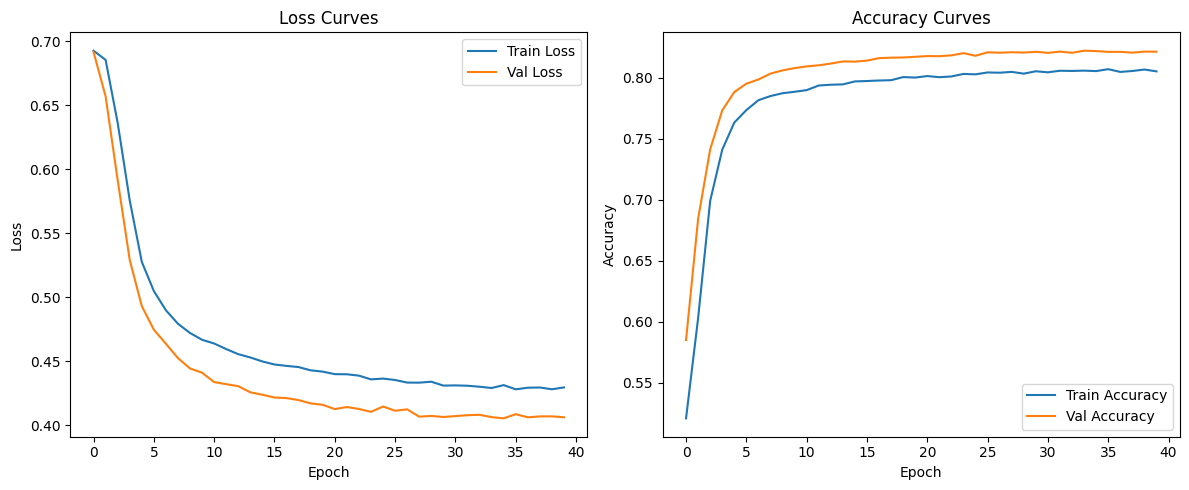

In [15]:
trained_model = trainer.train()

In [16]:
# 5. Visualization of attention weights

def visualize_attention(model, tokenizer, text, device, max_tokens=50, max_sentences=5):
    """Visualize both word and sentence level attention for a given text"""
    model.eval()
    
    # Preprocess text
    try:
        sentences = nltk.tokenize.sent_tokenize(text)
        if len(sentences) > max_sentences:
            sentences = sentences[:max_sentences]
    except:
        sentences = [text]
        
    # Tokenize
    enc = collate_fn([(sentences, 0)], tokenizer, max_tokens=max_tokens)
    input_ids, attn_mask, sent_mask, _ = [x.to(device) for x in enc]
    
    # Get predictions and attention weights
    with torch.no_grad():
        logits, word_alpha, sent_alpha = model(input_ids, attn_mask, sent_mask)
        
    # Convert to probabilities
    prob = torch.sigmoid(logits).item()
    pred_label = 'Positive' if prob > 0.5 else 'Negative'
    
    # Set up plots
    fig = plt.figure(figsize=(15, 7))
    
    # 1. Sentence-level attention
    plt.subplot(1, 2, 1)
    sent_weights = sent_alpha[0].cpu().numpy()
    sent_idxs = np.arange(len(sentences))
    valid_sents = sent_mask[0].cpu().numpy()
    
    # Filter out padding sentences
    valid_sent_idxs = sent_idxs[valid_sents]
    valid_sent_weights = sent_weights[valid_sents]
    valid_sentences = [sentences[i] for i in valid_sent_idxs]
    
    # Sort sentences by attention weights
    sorted_idxs = np.argsort(valid_sent_weights)[::-1]
    sorted_sentences = [valid_sentences[i] for i in sorted_idxs]
    sorted_weights = valid_sent_weights[sorted_idxs]
    
    # Truncate if too many sentences
    if len(sorted_sentences) > 5:
        sorted_sentences = sorted_sentences[:5]
        sorted_weights = sorted_weights[:5]
        
    colors = plt.cm.viridis(sorted_weights / max(sorted_weights))
    bars = plt.barh(range(len(sorted_sentences)), sorted_weights, color=colors)
    plt.yticks(range(len(sorted_sentences)), 
               [f"{s[:40]}..." if len(s) > 40 else s for s in sorted_sentences])
    plt.title(f'Sentence-level Attention\nPrediction: {pred_label} ({prob:.2f})')
    plt.xlabel('Attention Weight')
    plt.tight_layout()
    
    # 2. Word-level attention for the most important sentence
    plt.subplot(1, 2, 2)
    most_important_sent_idx = valid_sent_idxs[np.argmax(valid_sent_weights)]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0, most_important_sent_idx].cpu().tolist())
    weights = word_alpha[0, most_important_sent_idx].cpu().numpy()
    
    # Get token mask
    token_mask = attn_mask[0, most_important_sent_idx].cpu().numpy()
    
    # Filter special tokens and padding
    special_tokens = ['<s>', '</s>', '<pad>']
    valid_tokens = []
    valid_weights = []
    
    for i, token in enumerate(tokens):
        if token_mask[i] == 1 and token not in special_tokens:
            valid_tokens.append(token)
            valid_weights.append(weights[i])
    
    # Convert to numpy arrays
    valid_tokens = np.array(valid_tokens)
    valid_weights = np.array(valid_weights)
    
    # Sort by attention weights
    sorted_idxs = np.argsort(valid_weights)[-10:][::-1]  # Top 10 tokens
    sorted_tokens = valid_tokens[sorted_idxs]
    sorted_weights = valid_weights[sorted_idxs]
    
    colors = plt.cm.viridis(sorted_weights / max(sorted_weights))
    bars = plt.barh(range(len(sorted_tokens)), sorted_weights, color=colors)
    plt.yticks(range(len(sorted_tokens)), sorted_tokens)
    plt.title(f'Word-level Attention\nMost important sentence: "{sentences[most_important_sent_idx][:40]}..."')
    plt.xlabel('Attention Weight')
    plt.tight_layout()
    
    plt.savefig('attention_visualization.png')
    plt.show()
    
    return {'prediction': pred_label, 'probability': prob}

In [17]:
# Visualize attention for a sample tweet
# sample_idx = np.random.randint(0, len(val_df))
# sample_text = val_df.iloc[sample_idx]['text']
# sample_label = val_df.iloc[sample_idx]['label']

sample_text="Hello, brothers today let's enjoy to our heart's content."

logger.info(f"Sample text: {sample_text}")
# logger.info(f"True label: {'Positive' if sample_label == 1 else 'Negative'}")



2025-04-15 17:17:23 - INFO - Sample text: Hello, brothers today let's enjoy to our heart's content.


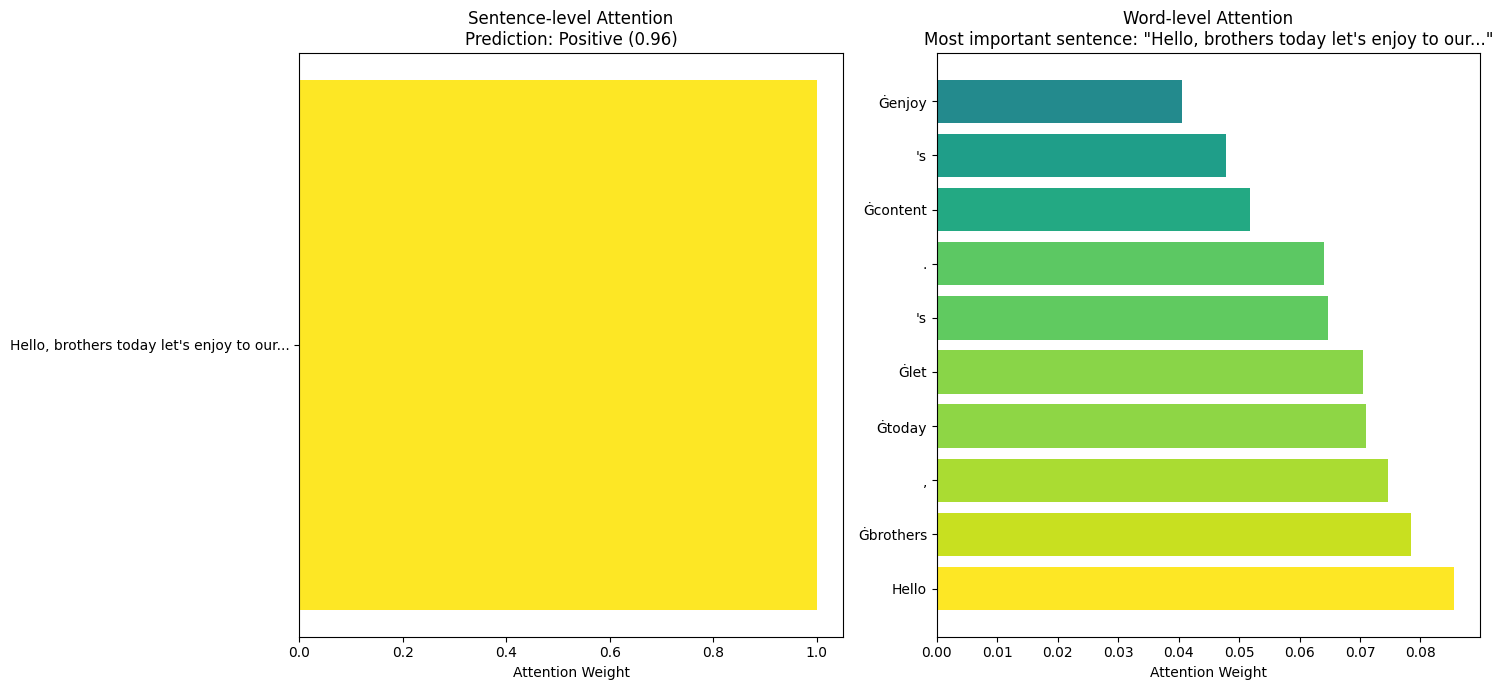

2025-04-15 17:17:23 - INFO - Prediction: Positive with confidence 0.9619


In [18]:
result = visualize_attention(
    model=trained_model,
    tokenizer=tokenizer,
    text=sample_text,
    device=DEVICE,
    max_tokens=MAX_TOKENS,
    max_sentences=MAX_SENTS
)

logger.info(f"Prediction: {result['prediction']} with confidence {result['probability']:.4f}")


In [19]:
gc.collect()
torch.cuda.empty_cache()